# Restricted Boltzmann Machine Demonstration

This document demonstrates how to **instantiate**, **train**, and **use** a Bernoulli-Bernoulli Restricted Boltzmann Machine (RBM).

### Contents
1. [Environment Setup](#1-environment-setup)
2. [Helper Functions](#2-helper-functions)
3. [Loading MNIST Dataset](#3-loading-mnist-dataset)
4. [Building the RBM with CD-k](#4-building-the-rbm)
5. [Training the RBM](#5-training-the-rbm)
6. [Tracking Free Energy & Reconstruction Loss](#6-tracking-free-energy--reconstruction-loss)
7. [Visualizing Reconstructions](#7-visualizing-reconstructions)

## 1. Environment Setup

In this section, we set up the environment that informs the RBM's architecture and training parameters.

In [39]:
"""1. Environment Setup & Imports"""

from typing                                 import List, Tuple

from matplotlib.pyplot                      import Axes, figure, show, subplot, subplots, tight_layout
from torch                                  import device as t_device, dtype as t_dtype, float32, no_grad, Tensor
from torch.cuda                             import is_available
from torch.optim                            import Adam
from torch.utils.data                       import DataLoader
from torchvision.datasets                   import MNIST
from torchvision.transforms                 import Compose, Lambda, ToTensor

from lucidium.neural.boltzmann_machines.rbm import RBM

# Define torch device and datatype.
# device: t_device =  t_device("cuda" if is_available() else "cpu")
device = "cpu"
dtype:  t_dtype =   float32

# Debug device and data type.
print(f"Device    = {device}\nData Type = {dtype}")

Device    = cpu
Data Type = torch.float32


## 2. Helper Functions

This section will define various helper functions used throughout the notebook.

In [40]:
"""2. Helper Functions"""

# Define helper function to binarize images.
def binarize(
    X:  Tensor,
    threshold:  float = 0.5
) -> Tensor:
    """# Binarize Image.
    
    ## Args:
        * X         (Tensor):   Tensor being binarized.
        * threshold (float):    Threshold around which values will be binarized.
    """
    return (X > threshold).to(X.dtype)

# Define protocol for a single epoch evaluation.
@no_grad()
def eval_epoch(
    rbm:    RBM,
    loader: DataLoader
) -> Tuple[float, float]:
    """# Evaluate RBM for One Epoch.

    ## Args:
        * rbm       (RBM):          RBM being evaluated.
        * loader    (DataLoader):   Data one which RBM will be evaluated.

    ## Returns:
        * float:    Free energy.
        * float:    Binary cross-entropy reconstruction loss.
    """
    # Place RBM in evaluation mode.
    rbm.eval()
    
    # Initialize running statistis.
    free_energy, bce_loss, data_size = 0.0, 0.0, 0
    
    # For each sample batch in loader...
    for batch in loader:
        
        # Place data on device.
        batch:  Tensor =        batch[0].to(device = device, dtype = dtype)
        
        # Forward pass to get visible data & probabilities.
        v_data, v_model, p_v =  rbm(batch)
        
        # Calculate free energy.
        free_energy +=          (rbm.free_energy(visible_batch = v_data) - \
                                rbm.free_energy(visible_batch = v_model)).item() * batch.size(0)
        
        # Calculate reconstruction loss.
        bce_loss +=             rbm.reconstruct(v_data = v_data, p_v = p_v).item() * batch.size(0)
        
        # Increment total data size.
        data_size +=            batch.size(0)
        
    # Provide free energy and reconstruction loss.
    return free_energy / data_size, bce_loss / data_size

# Define protocol for single epoch training.
def train_epoch(
    rbm:        RBM,
    loader:     DataLoader,
    optimizer:  Adam
) -> Tuple[float, float]:
    """# Train RBM for One Epoch.

    ## Args:
        * rbm       (RBM):          RBM being trained.
        * loader    (DataLoader):   Data one which RBM will be trained.
        * optimizer (Adam):         Training optimizer.

    ## Returns:
        * float:    Free energy.
        * float:    Binary cross-entropy reconstruction loss.
    """
    # Place RBM in training mode.
    rbm.train()
    
    # Initialize running statistis.
    free_energy, bce_loss, data_size = 0.0, 0.0, 0
    
    # For each sample batch in loader...
    for batch in loader:
        
        # Place data on device.
        batch:      Tensor =    batch[0].to(device = device, dtype = dtype)
        
        # Forward pass to get visible data & probabilities.
        v_data, v_model, p_v =  rbm(batch)
        
        # Compute contrastive divergence loss.
        cd_loss:    Tensor =    rbm.cd_loss(
                                    data_visible_batch =    v_data,
                                    model_visible_batch =   v_model
                                )
        
        # Reset gradients.
        optimizer.zero_grad()
        
        # Back propagation.
        cd_loss.backward()
        
        # Update weights.
        optimizer.step()
        
        # Aggregate statistics.
        with no_grad():
            
            free_energy +=  cd_loss.item() * batch.size(0)
            bce_loss +=     rbm.reconstruct(v_data = v_data, p_v = p_v) * batch.size(0)
            data_size +=    batch.size(0)
        
    # Provide free energy and reconstruction loss.
    return free_energy / data_size, bce_loss / data_size

## 3. Loading MNIST Dataset

In this section, we load and preprocess the MNIST dataset for training the RBM.

In [41]:
"""3. Loading MNIST Dataset"""

# Define image transform.
transform:      Compose =       Compose([
                                    ToTensor(),                         # Convert image to tensor.
                                    Lambda(lambda x: x.view(-1)),       # Flatten to (784,) shape.
                                    Lambda(lambda x: binarize(x, 0.5))  # Bernoulli visible units.
                                ])

# Load training & testing sets.
train_data:     MNIST =         MNIST(root = "../../../../datasets", train = True,  download = True, transform = transform)
test_data:      MNIST =         MNIST(root = "../../../../datasets", train = False, download = True, transform = transform)

# Initialize data loaders.
train_loader:   DataLoader =    DataLoader(dataset = train_data, batch_size = 128, shuffle = True, drop_last = True)
test_loader:    DataLoader =    DataLoader(dataset = test_data,  batch_size = 128, shuffle = True, drop_last = True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 10.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 662kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 6.32MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.4MB/s]


## 4. Building the RBM

In this section, we instantiate the RBM model with the specified architecture and training parameters.

In [42]:
"""4. Building the RBM"""

# Define RBM.
rbm:        RBM =   RBM(
                        visible_nodes = 784,    # MNIST images are 28x28 = 784 pixels
                        hidden_nodes =  500,
                        gibbs_steps =   5,
                        weight_scale =  1e-2,
                        device =        device,
                        dtype =         dtype
                    )

# Define optimizer.
optimizer:  Adam =  Adam(params = rbm.parameters(), lr = 1e-3)

# Debug initialization.
print(f"Initialized RBM: {rbm}")

Initialized RBM: RBM()


## 5. Training the RBM

In this section, we train the RBM using Contrastive Divergence (CD-k) and monitor its performance.

In [43]:
"""5. Training the RBM"""

# Initialize storage for trainin/testing statistics.
train_history:  List[Tuple[float, float]] = []
test_history:   List[Tuple[float, float]] = []

# Prescribe epochs.
epochs:         int =                       10

# For each training epoch...
for epoch in range(1, epochs + 1):
    
    # Train RBM.
    train_fe, train_bce =   train_epoch(rbm = rbm, loader = train_loader, optimizer = optimizer)
    
    # Record in history.
    train_history.append((train_fe, train_bce))
    
    # Evaluate RBM.
    eval_fe, eval_bce =     eval_epoch(rbm = rbm, loader = test_loader)
    
    # Record in history.
    test_history.append((eval_fe, eval_bce))
    
    print(
        f"[Epoch {epoch:2}/{epochs}] "
        f"CD-Loss (train/eval): {train_fe:.4f}/{eval_fe:.4f} | "
        f"Recon-BCE (train/eval): {train_bce:.4f}/{eval_bce:.4f}"
    )
    
    

[Epoch  1/10] CD-Loss (train/eval): -18.2811/-14.5324 | Recon-BCE (train/eval): 0.2402/0.1990
[Epoch  2/10] CD-Loss (train/eval): -15.2486/-15.5620 | Recon-BCE (train/eval): 0.1884/0.1779
[Epoch  3/10] CD-Loss (train/eval): -14.8727/-14.5293 | Recon-BCE (train/eval): 0.1725/0.1666
[Epoch  4/10] CD-Loss (train/eval): -13.7174/-14.3134 | Recon-BCE (train/eval): 0.1634/0.1584
[Epoch  5/10] CD-Loss (train/eval): -12.5952/-13.3906 | Recon-BCE (train/eval): 0.1570/0.1537
[Epoch  6/10] CD-Loss (train/eval): -11.6017/-11.0935 | Recon-BCE (train/eval): 0.1523/0.1500
[Epoch  7/10] CD-Loss (train/eval): -10.6402/-11.5741 | Recon-BCE (train/eval): 0.1486/0.1461
[Epoch  8/10] CD-Loss (train/eval): -9.9701/-10.0940 | Recon-BCE (train/eval): 0.1457/0.1442
[Epoch  9/10] CD-Loss (train/eval): -9.2315/-9.3082 | Recon-BCE (train/eval): 0.1433/0.1422
[Epoch 10/10] CD-Loss (train/eval): -8.5818/-8.9086 | Recon-BCE (train/eval): 0.1410/0.1395


## 6. Tracking Free Energy & Reconstruction Loss

In this section, we track the training and evaluation metrics, specifically the free energy and reconstruction loss, over the training epochs.

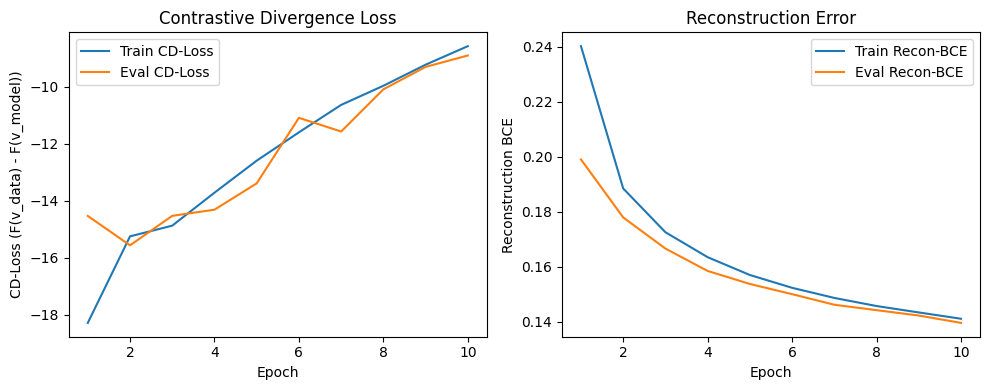

In [44]:
"""6. Plotting Results"""

# Extract statistics.
train_cd:   List[float] =   [x[0] for x in train_history]
eval_cd:    List[float] =   [x[0] for x in test_history]
train_bce:  List[float] =   [x[1] for x in train_history]
eval_bce:   List[float] =   [x[1] for x in test_history]

# Generate epochs range.
epochs:     range =         range(1, len(train_cd) + 1)

# Initialize subplots.
fig, axes = subplots(1, 2, figsize = (10, 4))

# Plot CD-Loss.
axes[0].plot(epochs, train_cd, label = "Train CD-Loss")
axes[0].plot(epochs, eval_cd,  label = "Eval CD-Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("CD-Loss (F(v_data) - F(v_model))")
axes[0].set_title("Contrastive Divergence Loss")
axes[0].legend()

# Plot Reconstruction BCE.
axes[1].plot(epochs, train_bce, label = "Train Recon-BCE")
axes[1].plot(epochs, eval_bce,  label = "Eval Recon-BCE")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Reconstruction BCE")
axes[1].set_title("Reconstruction Error")
axes[1].legend()

# Squeeze layout.
fig.tight_layout()

# Display plots.
show()

## 7. Visualizing Reconstructions

In this section, we visualize the reconstructions produced by the trained RBM on test data.

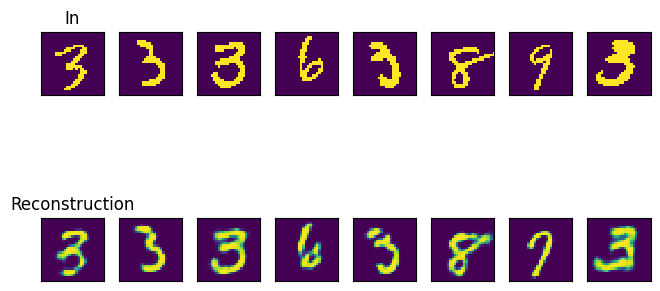

In [45]:
"""7. Visualize Reconstructions"""

# With no gradients...
with no_grad():
    
    # Place RBM in evaluation mode.
    rbm.eval()
    
    # Sample a batch.
    batch:      Tensor =    next(iter(test_loader))
    
    # Place batch on torch device.
    batch:      Tensor =    batch[0].to(device = device, dtype = dtype)
    
    # Forward pass through RBM.
    v_data, v_model, p_v =  rbm(batch[:8])
    
    # Normalize by probabilities.
    images_in:  Tensor =    v_data.view(-1, 1, 28, 28)
    images_out: Tensor =    p_v.view(-1, 1, 28, 28)
    
    # Initialize figure.
    figure()
    
    # For each sample...
    for i in range(8):
        
        # Plot input image.
        ax: Axes =  subplot(2, 8, i + 1)
        ax.imshow(images_in[i, 0], interpolation = "nearest")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("In" if i == 0 else "")
        
        # Plot output image.
        ax: Axes =  subplot(2, 8, 8 + i + 1)
        ax.imshow(images_out[i, 0], interpolation = "nearest")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("Reconstruction" if i == 0 else "")
        
    # Squeeze layout.
    tight_layout()
    
    # Display images.
    show()